# Embedding Model Selection

# Setup

In [106]:
import pandas as pd
import numpy as np
import os
import sys
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
colours = sns.color_palette("Set2")
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings("ignore")

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

-----

# Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve the relevant records, in order to isolate the text data that I will use to embed and select the best model. For this purpose, I will use the 12 funder-recipient pairs that I have curated for my evaluation app.

In [111]:
#get evaluation pairs and extract ids
evaluation_pairs = get_table_from_supabase(url, key, "evaluation_pairs")
funder_ids = evaluation_pairs["funder_registered_num"].unique()
eval_recip_ids = evaluation_pairs["recipient_id"].unique()

#add my ratings to compare later
ratings = {
    1: 0.25,
    2: 0.60,
    3: 0.25,
    4: 0.25,
    5: 0.10,
    6: 0.80,
    7: 0.60,
    8: 0.25,
    9: 0.25,
    10: 0.50,
    11: 0.80,
    12: 0.30
}
evaluation_pairs["my_rating"] = evaluation_pairs["id"].map(ratings)

In [112]:
#get the 12 funders and recipients
funders = get_table_from_supabase(url, key, "funders")
funders = funders[funders["registered_num"].isin(funder_ids)]

recipients = get_table_from_supabase(url, key, "recipients")
recipients = recipients[recipients["recipient_id"].isin(eval_recip_ids)]

#create dataframes
recipients_df = recipients.copy()
funders_df = funders.copy()

#add embedding columns to funder/recipient dfs
funders_df["embeddings"] = None
recipients_df["embeddings"] = None

#add funder and recipient names to pairs df
evaluation_pairs = evaluation_pairs.merge(
    funders_df[["registered_num", "name"]],
    left_on="funder_registered_num",
    right_on="registered_num",
    how="left"
)
evaluation_pairs = evaluation_pairs.rename(columns={"name": "funder_name"})
evaluation_pairs = evaluation_pairs.drop(columns=["registered_num"])
evaluation_pairs = evaluation_pairs.merge(
    recipients_df[["recipient_id", "recipient_name"]],
    on="recipient_id",
    how="left"
)

In [113]:
#check dfs
print(f"Recipients: {recipients_df.shape} | Funders: {funders_df.shape} | Evaluation Pairs: {evaluation_pairs.shape}")

Recipients: (12, 5) | Funders: (12, 14) | Evaluation Pairs: (12, 6)


----

# Embeddings Creation

I have chosen to test four models on my small evaluation dataset: 
- `all-MiniLM-L6-v2`
- `snowflake-arctic-embed-s`
- `all-roberta-large-v1`
- `bge-large-en-v1.5` 

Snowflake's model is generally finetuned for retrieval but I have decided to include it as it has performed so highly against other benchmarks and compared to major competitors (Merrick et al, 2024). The other models are consistent with the analysis by Pavlyshenko and Stasiuk (2025), who found these architectures to be reliable on semantic similarity tasks.

In [135]:
models = ["all-MiniLM-L6-v2", "Snowflake/snowflake-arctic-embed-s", "all-roberta-large-v1", "BAAI/bge-large-en-v1.5"]
results = []

#concat columns and replace NAs with empty strings
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("").str.lower()

In [136]:
#test both models
for model_name in models:
    model = SentenceTransformer(model_name)
    
    #make embeddings
    funders_ems = model.encode(funders_df["funders_text"].tolist())
    recipients_ems = model.encode(recipients_df["recipients_text"].tolist())
    
    #calculate similarities
    similarities = []
    for i in range(len(funders_df)):
        similarity = util.cos_sim(funders_ems[i], recipients_ems[i]).item()
        similarities.append(similarity)
    
    evaluation_pairs[f"{model_name}_sim"] = similarities
    
    #calculate correlation with my ratings
    corr = evaluation_pairs["my_rating"].corr(evaluation_pairs[f"{model_name}_sim"])
    
    results.append({
        "model": model_name,
        "correlation": corr
    })

#make dfs
evaluation_pairs = evaluation_pairs[["funder_name", "recipient_name","my_rating", 
                "all-MiniLM-L6-v2_sim", 
                "Snowflake/snowflake-arctic-embed-s_sim",
                "all-roberta-large-v1_sim",
                "BAAI/bge-large-en-v1.5_sim"]]
results_df = pd.DataFrame(results)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [137]:
#view pairs with scores from each model
evaluation_pairs

,funder_name,recipient_name,my_rating,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,BACON CHARITABLE TRUST,CATTON GROVE COMMUNITY CENTRE CIO,0.25,0.206052,0.584426,0.244338,0.440014
1,BEAVERBROOK FOUNDATION,FAITH IN LATER LIFE LTD,0.60,0.152812,0.752805,0.214820,0.432007
2,JESSIE SPENCER TRUST,COMBAT STRESS,0.25,0.178033,0.722730,0.181768,0.435000
3,GRUT TRUST,NORTHERN CANCER VOICES,0.25,0.331746,0.713746,0.339737,0.500169
4,JOHN WHIPPY FOUNDATION,ANIMAL RESCUE CYMRU,0.10,0.243448,0.644499,0.300965,0.473758
5,TESLER FOUNDATION,SEVENTH HEAVEN,0.60,0.328495,0.704759,0.266253,0.495646
6,FRIENDS OF FAWLEY CHURCH,"BERKSHIRE, BUCKINGHAMSHIRE AND OXFORDSHIRE WIL...",0.25,0.163585,0.617711,0.157783,0.501107
7,3 TS CHARITABLE TRUST,WELDMAR HOSPICECARE,0.25,0.206725,0.674962,0.138159,0.472200
8,DAVID AND RUTH BEHREND FUND,FREEDOM FROM TORTURE,0.50,0.144311,0.629727,0.169055,0.511933
9,MRS WATERHOUSE CHARITABLE TRUST,KIDZ KLUB - LEEDS,0.80,0.487164,0.716023,0.272006,0.625717


In [138]:
results_df

,model,correlation
0,all-MiniLM-L6-v2,0.629824
1,Snowflake/snowflake-arctic-embed-s,0.299794
2,all-roberta-large-v1,0.333517
3,BAAI/bge-large-en-v1.5,0.550222


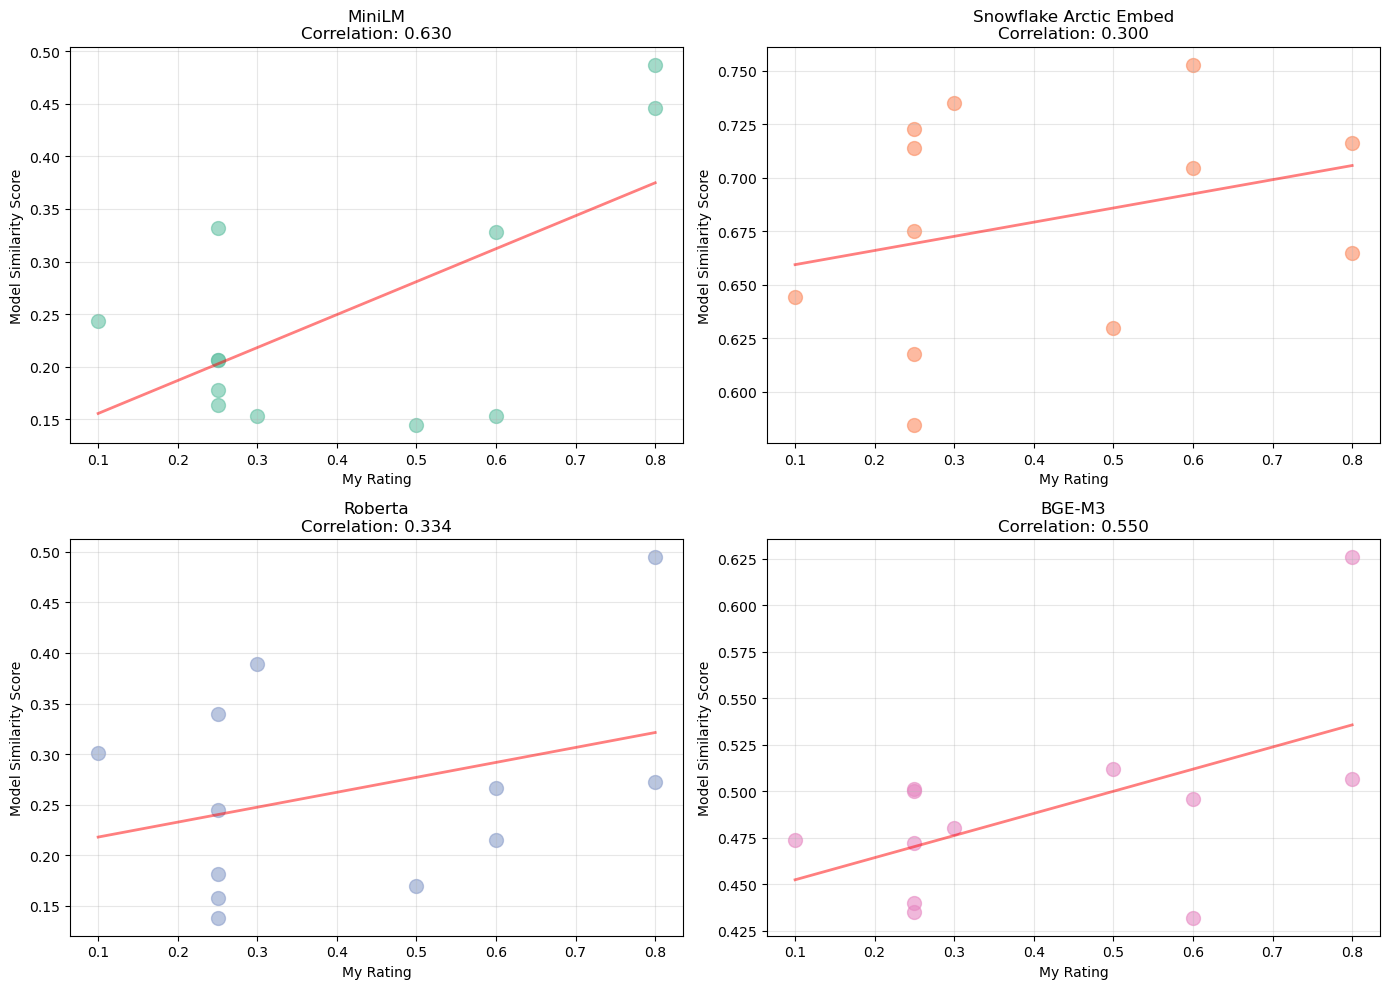

In [141]:
#make scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_col, title) in enumerate([
    ("all-MiniLM-L6-v2_sim", "MiniLM"),
    ("Snowflake/snowflake-arctic-embed-s_sim", "Snowflake Arctic Embed"),
    ("all-roberta-large-v1_sim", "Roberta"),
    ("BAAI/bge-large-en-v1.5_sim", "BGE-M3")
]):
    axes[idx].scatter(evaluation_pairs["my_rating"], evaluation_pairs[model_col],
                        alpha=0.6, s=100, color=colours[idx])

    #show line of best fit
    z = np.polyfit(evaluation_pairs["my_rating"], evaluation_pairs[model_col], 1)
    p = np.poly1d(z)
    axes[idx].plot(evaluation_pairs["my_rating"].sort_values(),
                    p(evaluation_pairs["my_rating"].sort_values()),
                    "r-", alpha=0.5, linewidth=2)

    axes[idx].set_xlabel("My Rating")
    axes[idx].set_ylabel("Model Similarity Score")
    axes[idx].set_title(f"{title}\nCorrelation: {results_df.iloc[idx]['correlation']:.3f}")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()